In [1]:
from sparse_recon.sparse_deconv import sparse_deconv
from pathlib import Path
import matplotlib
import scipy
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from readlif.reader import LifFile

## 1. Check how our deconvotution approach works:

In [2]:
data_to_transcriptomics ="../../../labdata/translatome/mAD_64gene/9919rawdata" 

In [3]:
example1 = Path(data_to_transcriptomics) / "20210226_9919_A2"

In [4]:
im = io.imread( example1 / "test_9919sub1_round2_C0.tif")

In [5]:
lif = LifFile(example1 / "9919seqA2.lif")
print(f"Found {len(lif.image_list)}")

Found 1


In [6]:
for image in lif.get_iter_image():
    print(f"Experiment : {image.name}")
    print(f"Dims: {image.dims}")  # e.g., (5, 3, 512, 512) - time, channel, x, y
    print(f"Scale: {image.scale}")     #  nm/pixel or µm/pixel? 
    print(f'Wave lenth: {image.settings["EmissionWavelengthForPinholeAiryCalculation"]}')     # nm
    print(f'Numerical Aperture: {image.settings["NumericalAperture"]}')    # nm

Experiment : TileScan_001
Dims: Dims(x=3072, y=3072, z=30, t=1, m=56)
Scale: (10.566881720430107, 10.566881720430107, 2.888046376049531, None)
Wave lenth: 580
Numerical Aperture: 1.3


In [7]:
pixelsize = image.scale[0] #(nm)
resolution = 0.61* float(image.settings["EmissionWavelengthForPinholeAiryCalculation"]) / float(image.settings["NumericalAperture"]) #(nm)

In [8]:
image_frame =image.get_frame(10)

In [9]:
np.array(image_frame).shape

(3072, 3072)

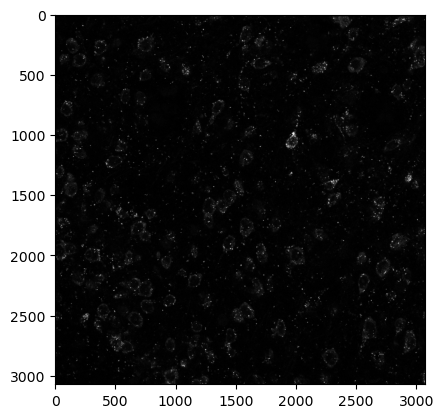

In [10]:
plt.imshow(image_frame,cmap = 'gray')
plt.show()

In [11]:
im[10, :, :].shape

(3072, 3072)

Content-aware parameters (from "Weisong Zhao et al. Sparse deconvolution improves the resolution of live-cell super-resolution fluorescence microscopy, Nature Biotechnology (2021)"):  
**Image fidelity (Step 1)**: This parameter denotes the distance between the image before and after the sparse reconstruction and is the inverse of the xy continuity. Usually, we use a large value (1000~300) for high SNR images. 

**Sparsity (Step 1)**: This parameter represents the relative sparsity constraint enforced on the reconstruction (Step 1). Usually, we pre-set this value to one-tenth of the image fidelity term . 

In [12]:
img_recon = sparse_deconv(img =im[10,:,:], sigma=resolution / pixelsize, fidelity=1000)

Start the Sparse deconvolution...
0 iterations done
1 iterations done
2 iterations done
3 iterations done
4 iterations done
5 iterations done
6 iterations done
7 iterations done
8 iterations done
9 iterations done
10 iterations done
11 iterations done
12 iterations done
13 iterations done
14 iterations done
15 iterations done
16 iterations done
17 iterations done
18 iterations done
19 iterations done
20 iterations done
21 iterations done
22 iterations done
23 iterations done
24 iterations done
25 iterations done
26 iterations done
27 iterations done
28 iterations done
29 iterations done
30 iterations done
31 iterations done
32 iterations done
33 iterations done
34 iterations done
35 iterations done
36 iterations done
37 iterations done
38 iterations done
39 iterations done
40 iterations done
41 iterations done
42 iterations done
43 iterations done
44 iterations done
45 iterations done
46 iterations done
47 iterations done
48 iterations done
49 iterations done
50 iterations done
51 iter

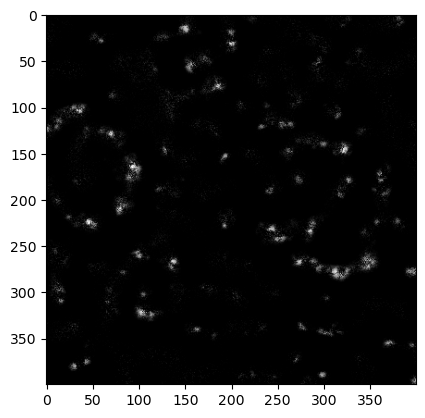

In [13]:
plt.imshow(img_recon[100:500,100:500] / img_recon[:,:].max() * 255,cmap = 'gray')
plt.show()

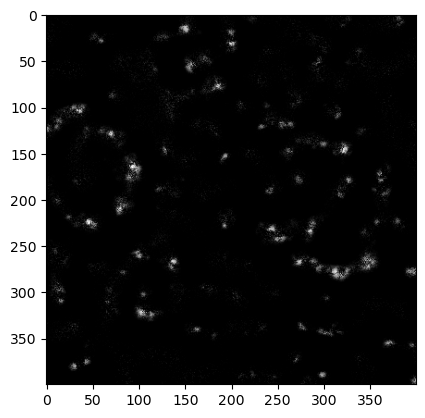

In [14]:
plt.imshow(img_recon[100:500,100:500] / img_recon[:,:].max() * 255,cmap = 'gray')
plt.show()

## 2. Run deconvolution for all parts of data

We need to organize images according to this order:


### Folder structure
sample-dataset (Dataset ID):
- round1 (sequencing round number)
    - FOV1 (FOV ID)
        - ch01.tif (3D image stack for individual channel)
        - ch02.tif
        - ch03.tif
        - ch04.tif
        - …
    - FOV2
        - …
- round2
- …
- genes.csv


In [15]:
result_dir ="../../../output-mAD_44gene"

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_two_images(img1, img2, title1="Image 1", title2="Image 2",
                    vmin=None, vmax=None, cmap="gray"):
    """
    Показывает два изображения рядом.
    
    img1, img2 — numpy массивы (2D или 3D срез).
    title1, title2 — названия картинок.
    vmin, vmax — опциональная нормализация (например 0, 255).
    cmap — цветовая карта.
    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title(title1)
    axs[0].axis("off")

    axs[1].imshow(img2, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title(title2)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


In [17]:
import os
import re
import tifffile
pattern = re.compile(r"A\d+$") # your pattern here

# all directories that contain rounds
round_dirs = [d for d in os.listdir(data_to_transcriptomics)
              if os.path.isdir(os.path.join(data_to_transcriptomics, d)) and pattern.search(d)]

print("Found rounds:", round_dirs)

Found rounds: ['20210225_9919_A1', '20210226_9919_A2', '20210226_9919_A3', '20210227_9919_A4']


In [18]:
# Create result directory with rounds
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [23]:
FIDELITY = 500
SPARSITY = 10

In [ ]:
for i, elem in enumerate(round_dirs):
    round_path = Path(result_dir) / f"round{i}"
    if not os.path.exists(round_path):
        os.mkdir(round_path)
    # Create only one FOV in each round ( we have such data, you can fix it)
    fov_path = round_path / "FOV1"
    if not os.path.exists(fov_path):
        os.mkdir(fov_path)
    ## Starting deconvolve each image frame by frame
    ## Firstly find lif and read context information 
    lif_file = [f for f in os.listdir(Path(data_to_transcriptomics) /elem) if f.endswith(".lif")][0]
    print("Found lif_file: ", lif_file)
    lif = LifFile(Path(data_to_transcriptomics) / elem / lif_file)
    lif_image = next(lif.get_iter_image())
    pixelsize = lif_image.scale[0] #(nm)
    resolution = 0.61* float(lif_image.settings["EmissionWavelengthForPinholeAiryCalculation"]) / float(lif_image.settings["NumericalAperture"])
    
    tif_files = [f for f in os.listdir(Path(data_to_transcriptomics) /elem) if f.endswith(".tif")]
    print("Found tif_files: ", tif_files)
    for tif in tif_files:
        im = io.imread( Path(data_to_transcriptomics) / elem / tif)
        print("im.shape: ", im.shape)
        img_reconst_array = []
        for i in range(im.shape[0]):
            img_recon = sparse_deconv(img =im[i,:,:], sigma=resolution / pixelsize, fidelity=FIDELITY, sparsity=SPARSITY)
            img_reconst_array.append(img_recon.copy())
        final_reconst_image = np.stack(img_reconst_array)
        # Draw now random frame
        frame_id = np.random.randint(im.shape[0])
        print("final_reconst_image.shape: ", final_reconst_image.shape)
        show_two_images(im[frame_id,300:699, 300:600], final_reconst_image[frame_id,300:699, 300:600], title1="Original", title2="Deconvolved",
                    vmin=None, vmax=None, cmap="gray")
        
        new_tif_name =tif.replace('_C','_ch0')
        print("Saving to.....", fov_path /new_tif_name)
        tifffile.imwrite(fov_path /new_tif_name, final_reconst_image)

Found lif_file:  9919seqA1.lif
Found tif_files:  ['9919seqA1.lif - TileScan_005 - C=0.tif', '9919seqA1.lif - TileScan_005 - C=1.tif', '9919seqA1.lif - TileScan_005 - C=2.tif', '9919seqA1.lif - TileScan_005 - C=3.tif', '9919seqA1.lif - TileScan_005 - C=4.tif', '9919seqA1.lif - TileScan_005.tif', 'Composite_raw1.tif', 'test_9919sub1_round1_C0.tif', 'test_9919sub1_round1_C1.tif', 'test_9919sub1_round1_C2.tif', 'test_9919sub1_round1_C3.tif', 'test_9919sub1_round1_C4.tif']
im.shape:  (30, 3072, 3072)
Start the Sparse deconvolution...
0 iterations done
1 iterations done
2 iterations done
3 iterations done
4 iterations done
5 iterations done
6 iterations done
7 iterations done
8 iterations done
9 iterations done
10 iterations done
11 iterations done
12 iterations done
13 iterations done
14 iterations done
15 iterations done
16 iterations done
17 iterations done
18 iterations done
19 iterations done
20 iterations done
21 iterations done
22 iterations done
23 iterations done
24 iterations done
